In [1]:
import xarray as xr
import xcdat as xc
import numpy as np
import xskillscore as xs
import xesmf

Summary:
This notebook compares using native xesmf adapative regridding method, and the methods supported by xcdat, for regridding a dataset with ocean mask.
In the results shown in this case:
1. Bilinear method preserves the metrics better in terms of area-weighted integral and mean;mean values from conservative methods are higher when (na_thres = 1; more missing points, nans) and lower when (na_thres = 0; less missing points, nans)
2. RMSE values are smaller with conservative methods. 
3. The conservative methods from xcdat application has issues with low absolute values around coastal lines.(see below figures) 


In [2]:
f_a = '/Users/zhang40/Downloads/ERA5-TREFHT-ANN-land_test_30yrs.nc' 
f_b = '/Users/zhang40/Downloads/ERA5-TREFHT-ANN-land_ref_30yrs.nc' 

In [3]:
tas_a = xr.open_dataset(f_a)
tas_b = xr.open_dataset(f_b)
tas_a = tas_a.bounds.add_missing_bounds()
tas_b = tas_b.bounds.add_missing_bounds()

In [4]:
test_grid_with_bounds = {'lon': tas_a['lon'],
                           'lat': tas_a['lat'],

                           'lon_b': tas_a['lon_bnds'],
                           'lat_b': tas_a['lat_bnds'],
                           'lon_b': np.unique(np.sort(tas_a['lon_bnds'].values.flatten())),
                           'lat_b': np.unique(np.sort(tas_a['lat_bnds'].values.flatten())),
                          }

ref_grid_with_bounds = {'lon': tas_b['lon'],
                           'lat': tas_b['lat'],
                           'lon_b': tas_b['lon_bnds'],
                           'lat_b': tas_b['lat_bnds'],
                           'lon_b': np.unique(np.sort(tas_b['lon_bnds'].values.flatten())),
                           'lat_b': np.unique(np.sort(tas_b['lat_bnds'].values.flatten())),

                          }

In [5]:
xesmf_reg = False   # False for xcdat regridding
                    # True for using xesmf_reg, which requires assigning bounds manually

In [6]:
# Adaptive regridding supported by xesmf:https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Masking.html#Adaptive-masking
# Also discussed here:https://github.com/pangeo-data/xESMF/issues/256#issuecomment-2198071089
#In case skipna is active, a given output point is set to NaN only if the ratio of missing values exceeds the threshold level set by na_thres, and else, a renormalization is conducted. 

if xesmf_reg:
    na_thres = 0    # the threshold of ratio of missing points, 0 means any nan from source will flaged as nan in target grid, yielding more nans
    regridder = xesmf.Regridder(ref_grid_with_bounds, test_grid_with_bounds, method="bilinear", periodic= True)
    tas_b_coarse_bilinear = regridder(
        tas_b.TREFHT,
        skipna=True,
        na_thres=na_thres,  # lowering this results in more NaNs in ds_coarse
    )

    regridder = xesmf.Regridder(ref_grid_with_bounds, test_grid_with_bounds, method="conservative", periodic= True)
    tas_b_coarse_conservative = regridder(
        tas_b.TREFHT,
        skipna=True,
        na_thres=na_thres,  # lowering this results in more NaNs in ds_coarse
    )

    regridder = xesmf.Regridder(ref_grid_with_bounds, test_grid_with_bounds, method="conservative_normed", periodic= True)
    tas_b_coarse_normed = regridder(
        tas_b.TREFHT,
        skipna=True,
        na_thres=na_thres,  # lowering this results in more NaNs in ds_coarse
    )
else:
    tas_a["mask"] = xr.where(~np.isnan(tas_a.TREFHT), 1, 0)
    output_grid = tas_a.regridder.grid

    tas_b["mask"] = xr.where(~np.isnan(tas_b.TREFHT), 1, 0)

    tas_b_regrid_bilinear = tas_b.regridder.horizontal(
                'TREFHT', output_grid, tool='xesmf', method='bilinear'
            )

    tas_b_regrid_conservative_normed = tas_b.regridder.horizontal(
                'TREFHT', output_grid, tool='xesmf', method='conservative_normed'
            )

    tas_b_regrid_conservative = tas_b.regridder.horizontal(
                'TREFHT', output_grid, tool='xesmf', method='conservative'
            )
    tas_b_coarse_bilinear = tas_b_regrid_bilinear.TREFHT
    tas_b_coarse_conservative = tas_b_regrid_conservative.TREFHT
    tas_b_coarse_normed = tas_b_regrid_conservative_normed.TREFHT

In [8]:
# Verify if rmse from xs is same as simple calculation
weights = tas_a.spatial.get_weights(["X","Y"], data_var='TREFHT')
weights0 = tas_b.spatial.get_weights(["X","Y"], data_var='TREFHT')

result_xr_bilinear = xs.rmse(tas_a['TREFHT'], tas_b_coarse_bilinear, dim=["lat", "lon"], weights=weights, skipna=True)
rmse_bilinear = np.sqrt(((tas_a['TREFHT'] -tas_b_coarse_bilinear) ** 2).mean(skipna=True))
print('xs. rmse bilinear', result_xr_bilinear.values, 'direct calculation (unweighted)', rmse_bilinear.values)

result_xr_conservative = xs.rmse(tas_a['TREFHT'], tas_b_coarse_conservative, dim=["lat", "lon"], weights=weights, skipna=True)
rmse_conserve = np.sqrt(((tas_a['TREFHT'] -tas_b_coarse_conservative) ** 2).mean(skipna=True))
print('xs. rmse conserve', result_xr_conservative.values, 'direct calculation (unweighted)', rmse_conserve.values)

result_xr_conservative_normed = xs.rmse(tas_a['TREFHT'], tas_b_coarse_normed, dim=["lat", "lon"], weights=weights, skipna=True)
rmse_normed = np.sqrt(((tas_a['TREFHT'] -tas_b_coarse_normed) ** 2).mean(skipna=True))
print('xs. rmse cons_normed', result_xr_conservative_normed.values, 'direct calculation (unweighted)', rmse_normed.values)


print('--------------------------------')
print('area-weighted integral and mean')

print('Original',tas_b.TREFHT.weighted(weights0).sum(dim=['lat','lon']).values,tas_b.TREFHT.weighted(weights0).mean(dim=['lat','lon']).values)
print('bilinear',tas_b_coarse_bilinear.weighted(weights).sum(dim=['lat','lon']).values, tas_b_coarse_bilinear.weighted(weights).mean(dim=['lat','lon']).values)
print('conservative',tas_b_coarse_conservative.weighted(weights).sum(['lat','lon']).values,tas_b_coarse_conservative.weighted(weights).mean(['lat','lon']).values)
print('cons. normed',tas_b_coarse_normed.weighted(weights).sum(['lat','lon']).values,tas_b_coarse_normed.weighted(weights).mean(['lat','lon']).values)

xs. rmse bilinear 1.922178277475824 direct calculation (unweighted) 2.0545359
xs. rmse conserve 1.9327170200085688 direct calculation (unweighted) 2.0316942
xs. rmse cons_normed 1.6641886252155613 direct calculation (unweighted) 1.8655692
--------------------------------
area-weighted integral and mean
Original 1771.0478512460706 8.925866308570766
bilinear 1780.0737247011489 8.942385547795508
conservative 1770.9782811137118 8.254372334569997
cons. normed 1967.657722299666 9.171077725831532


/Users/zhang40/mambaforge/envs/e3sm-unified/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/zhang40/mambaforge/envs/e3sm-unified/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


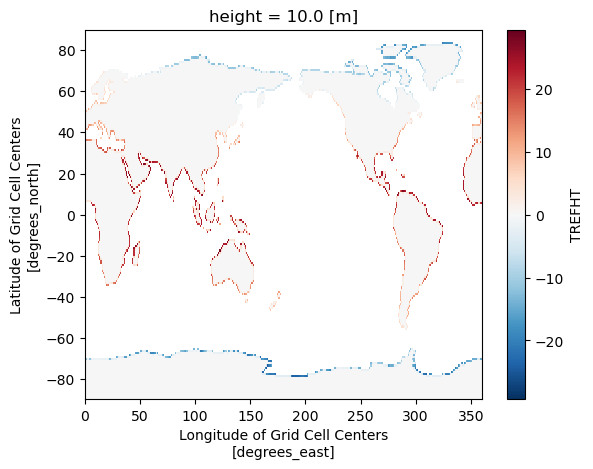

In [9]:
diff = tas_b_regrid_conservative_normed.TREFHT-tas_b_regrid_conservative.TREFHT
diff.plot()

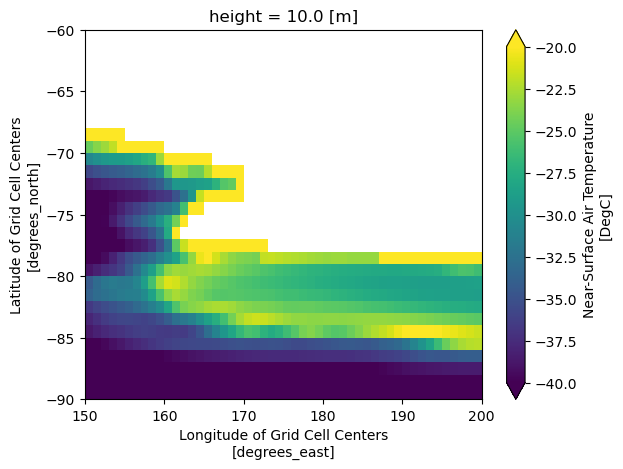

In [10]:
tas_b_regrid_conservative.TREFHT.plot(xlim=(150,200), ylim=(-90,-60),vmin = -40, vmax = -20)

In [11]:
# Find the index where conservative and conservative_norm diff
#diff_non_zeros = diff.where(diff > 0, drop=True)
data1d = diff.where(diff != 0, drop=True).stack(points=("lat", "lon")).dropna(dim="points")

In [13]:
data1d.points.shape

(3136,)

In [14]:
# Extract data for each lat/lon pair
results = []
for lat, lon in data1d.points.values:
    
    original = tas_b.TREFHT.sel(lat=lat, lon=lon)#, method="nearest")  # Use "nearest" if exact match isn't guaranteed
    bilinear = tas_b_regrid_bilinear.TREFHT.sel(lat=lat, lon=lon)#, method="nearest")  # Use "nearest" if exact match isn't guaranteed
    conserve = tas_b_regrid_conservative.TREFHT.sel(lat=lat, lon=lon)
    normed = tas_b_regrid_conservative_normed.TREFHT.sel(lat=lat, lon=lon)

    #results.append(original_data.item())  # Convert xarray object to a Python scalar
    print('lat,lon,orig,line,cons,normed', lat, lon, original.item(), bilinear.item(),conserve.item(), normed.item() )
print(results)

lat,lon,orig,line,cons,normed -78.5 172.5 -24.493581771850586 -24.493581771850586 -21.808378219604492 -24.59235382080078
lat,lon,orig,line,cons,normed -78.5 173.5 -24.765966415405273 -24.765966415405273 -21.720922470092773 -24.949541091918945
lat,lon,orig,line,cons,normed -78.5 174.5 -25.2132625579834 -25.2132625579834 -21.9981689453125 -25.26799774169922
lat,lon,orig,line,cons,normed -78.5 175.5 -25.51202964782715 -25.51202964782715 -22.200057983398438 -25.499895095825195
lat,lon,orig,line,cons,normed -78.5 176.5 -25.722829818725586 -25.722829818725586 -22.36014175415039 -25.683774948120117
lat,lon,orig,line,cons,normed -78.5 177.5 -25.95699119567871 -25.95699119567871 -22.575992584228516 -25.931711196899414
lat,lon,orig,line,cons,normed -78.5 178.5 -26.156042098999023 -26.156042098999023 -22.799821853637695 -26.188810348510742
lat,lon,orig,line,cons,normed -78.5 179.5 -26.11726951599121 -26.11726951599121 -22.944625854492188 -26.35513687133789
lat,lon,orig,line,cons,normed -78.5 180.

lat,lon,orig,line,cons,normed -66.5 52.5 -17.65082359313965 -17.65082359313965 -13.72437858581543 -17.60517120361328
lat,lon,orig,line,cons,normed -66.5 53.5 -19.26308250427246 -19.26308250427246 -17.147390365600586 -19.634737014770508
lat,lon,orig,line,cons,normed -66.5 54.5 -20.300512313842773 -20.300512313842773 -16.178903579711914 -20.753751754760742
lat,lon,orig,line,cons,normed -66.5 55.5 nan nan -2.348888397216797 -19.052074432373047
lat,lon,orig,line,cons,normed -66.5 56.5 nan nan -0.2531155049800873 -16.46930503845215
lat,lon,orig,line,cons,normed -66.5 86.5 nan nan -1.440060019493103 -13.343913078308105
lat,lon,orig,line,cons,normed -66.5 87.5 nan nan -1.7674140930175781 -14.335678100585938
lat,lon,orig,line,cons,normed -66.5 88.5 nan nan -1.8909528255462646 -15.337713241577148
lat,lon,orig,line,cons,normed -66.5 89.5 nan nan -1.8592474460601807 -15.080547332763672
lat,lon,orig,line,cons,normed -66.5 90.5 nan nan -2.0878489017486572 -16.934757232666016
lat,lon,orig,line,cons,

lat,lon,orig,line,cons,normed -15.5 49.5 20.802881240844727 20.802881240844727 16.216405868530273 20.76045036315918
lat,lon,orig,line,cons,normed -15.5 124.5 nan nan 2.891430616378784 26.441099166870117
lat,lon,orig,line,cons,normed -15.5 125.5 25.664880752563477 25.664880752563477 22.92037582397461 25.732236862182617
lat,lon,orig,line,cons,normed -15.5 135.5 26.29314613342285 26.29314613342285 25.995378494262695 26.408533096313477
lat,lon,orig,line,cons,normed -15.5 136.5 nan nan 5.315608978271484 26.154964447021484
lat,lon,orig,line,cons,normed -15.5 141.5 26.98577308654785 26.98577308654785 20.974811553955078 26.843551635742188
lat,lon,orig,line,cons,normed -15.5 144.5 25.597436904907227 25.597436904907227 20.177114486694336 25.317047119140625
lat,lon,orig,line,cons,normed -15.5 145.5 nan nan 0.35785531997680664 22.932275772094727
lat,lon,orig,line,cons,normed -15.5 285.5 18.571741104125977 18.571741104125977 12.798396110534668 16.718669891357422
lat,lon,orig,line,cons,normed -15.5 

lat,lon,orig,line,cons,normed 12.5 102.5 26.22307777404785 26.22307777404785 20.7726993560791 26.06483268737793
lat,lon,orig,line,cons,normed 12.5 108.5 22.93255043029785 22.93255043029785 18.402217864990234 23.551715850830078
lat,lon,orig,line,cons,normed 12.5 272.5 nan nan 0.44839444756507874 28.72637367248535
lat,lon,orig,line,cons,normed 12.5 273.5 28.12761878967285 28.12761878967285 24.259355545043945 27.23900604248047
lat,lon,orig,line,cons,normed 12.5 275.5 25.13591957092285 25.13591957092285 22.242727279663086 24.97468376159668
lat,lon,orig,line,cons,normed 12.5 276.5 nan nan 0.39849352836608887 25.52947425842285
lat,lon,orig,line,cons,normed 12.5 343.5 nan nan 2.9920027256011963 27.359766006469727
lat,lon,orig,line,cons,normed 12.5 344.5 27.4830265045166 27.4830265045166 27.179100036621094 27.610946655273438
lat,lon,orig,line,cons,normed 13.5 41.5 29.38604164123535 29.38604164123535 29.668350219726562 30.138748168945312
lat,lon,orig,line,cons,normed 13.5 42.5 nan nan 3.1883792

lat,lon,orig,line,cons,normed 33.5 352.5 nan nan 3.8941311836242676 17.801471710205078
lat,lon,orig,line,cons,normed 33.5 353.5 17.565088272094727 17.565088272094727 15.434317588806152 17.330734252929688
lat,lon,orig,line,cons,normed 34.5 10.5 nan nan 4.442506313323975 20.317697525024414
lat,lon,orig,line,cons,normed 34.5 36.5 16.2215518951416 16.2215518951416 13.948492050170898 15.941132545471191
lat,lon,orig,line,cons,normed 34.5 119.5 14.552881240844727 14.552881240844727 12.709918022155762 14.525618553161621
lat,lon,orig,line,cons,normed 34.5 132.5 14.562616348266602 14.562616348266602 8.24609661102295 14.659659385681152
lat,lon,orig,line,cons,normed 34.5 134.5 16.736474990844727 16.736474990844727 10.808809280395508 16.470489501953125
lat,lon,orig,line,cons,normed 34.5 135.5 16.2454776763916 16.2454776763916 13.222845077514648 15.385858535766602
lat,lon,orig,line,cons,normed 34.5 136.5 nan nan 2.955869436264038 14.549290657043457
lat,lon,orig,line,cons,normed 34.5 240.5 15.6043643

lat,lon,orig,line,cons,normed 56.5 271.5 -5.735876560211182 -5.735876560211182 -4.278868675231934 -5.471185684204102
lat,lon,orig,line,cons,normed 56.5 272.5 nan nan -0.07806278020143509 -4.946508884429932
lat,lon,orig,line,cons,normed 56.5 283.5 nan nan -0.5929887890815735 -4.743824481964111
lat,lon,orig,line,cons,normed 56.5 297.5 -4.133245944976807 -4.133245944976807 -4.155065059661865 -4.2203450202941895
lat,lon,orig,line,cons,normed 56.5 298.5 -3.4462647438049316 -3.4462647438049316 -2.527926445007324 -3.298907518386841
lat,lon,orig,line,cons,normed 56.5 354.5 nan nan 0.6948692202568054 7.41170597076416
lat,lon,orig,line,cons,normed 56.5 355.5 6.567681789398193 6.567681789398193 6.838659286499023 7.059256076812744
lat,lon,orig,line,cons,normed 56.5 357.5 9.020502090454102 9.020502090454102 6.965527534484863 8.910059928894043
lat,lon,orig,line,cons,normed 57.5 12.5 7.233392238616943 7.233392238616943 6.346206188201904 7.25282621383667
lat,lon,orig,line,cons,normed 57.5 16.5 7.61049

lat,lon,orig,line,cons,normed 68.5 274.5 -14.203374862670898 -14.203374862670898 -13.686610221862793 -13.899822235107422
lat,lon,orig,line,cons,normed 68.5 277.5 nan nan -1.7074111700057983 -13.658926010131836
lat,lon,orig,line,cons,normed 68.5 285.5 -11.404150009155273 -11.404150009155273 -8.788999557495117 -11.504453659057617
lat,lon,orig,line,cons,normed 68.5 286.5 -11.454473495483398 -11.454473495483398 -10.310951232910156 -11.598783493041992
lat,lon,orig,line,cons,normed 68.5 291.5 -13.191808700561523 -13.191808700561523 -11.756792068481445 -13.175628662109375
lat,lon,orig,line,cons,normed 68.5 292.5 -11.603033065795898 -11.603033065795898 -10.708812713623047 -12.211088180541992
lat,lon,orig,line,cons,normed 68.5 293.5 -10.389379501342773 -10.389379501342773 -7.250157356262207 -10.785897254943848
lat,lon,orig,line,cons,normed 68.5 307.5 nan nan -0.6021645665168762 -5.490987777709961
lat,lon,orig,line,cons,normed 68.5 308.5 -5.539648532867432 -5.539648532867432 -5.331151008605957 -

lat,lon,orig,line,cons,normed 81.5 340.5 nan nan -2.0299153327941895 -17.6895694732666
lat,lon,orig,line,cons,normed 82.5 270.5 nan nan -1.9611657857894897 -16.975465774536133
lat,lon,orig,line,cons,normed 82.5 271.5 nan nan -2.5028903484344482 -18.953584671020508
lat,lon,orig,line,cons,normed 82.5 272.5 nan nan -2.3586478233337402 -20.415992736816406
lat,lon,orig,line,cons,normed 82.5 280.5 nan nan -2.4537835121154785 -21.23946762084961
lat,lon,orig,line,cons,normed 82.5 281.5 nan nan -2.851078987121582 -21.59030532836914
lat,lon,orig,line,cons,normed 82.5 282.5 -20.647619247436523 -20.647619247436523 -16.044118881225586 -20.35183334350586
lat,lon,orig,line,cons,normed 82.5 283.5 -20.32259178161621 -20.32259178161621 -17.86941909790039 -20.257984161376953
lat,lon,orig,line,cons,normed 82.5 284.5 -20.260351181030273 -20.260351181030273 -18.015810012817383 -20.42394256591797
lat,lon,orig,line,cons,normed 82.5 285.5 -20.461034774780273 -20.461034774780273 -18.084890365600586 -20.50225639

In [15]:
def print_stats(arr1, arr2, label1="Array 1", label2="Array 2"):
    stats = {
        "Min": (np.min(arr1), np.min(arr2)),
        "Max": (np.max(arr1), np.max(arr2)),
        "Mean": (np.mean(arr1), np.mean(arr2)),
        "Std": (np.std(arr1), np.std(arr2)),
    }
    
    print(f"{'Stat':<10} {label1:<15} {label2:<15}")
    print("-" * 40)
    for stat, values in stats.items():
        print(f"{stat:<10} {values[0]:<15.6f} {values[1]:<15.6f}")

In [16]:
print_stats(tas_b.TREFHT, tas_b_regrid_conservative.TREFHT)

Stat       Array 1         Array 2        
----------------------------------------
Min        -53.482216      -53.193939     
Max        33.916008       31.726822      
Mean       -5.335422       -4.895763      
Std        25.083681       24.112719      


In [17]:
print_stats(tas_b.TREFHT, tas_b_regrid_conservative_normed.TREFHT)

Stat       Array 1         Array 2        
----------------------------------------
Min        -53.482216      -53.193939     
Max        33.916008       31.726822      
Mean       -5.335422       -4.591918      
Std        25.083681       24.693712      


In [18]:
print_stats(tas_b.TREFHT, tas_b_regrid_bilinear.TREFHT)

Stat       Array 1         Array 2        
----------------------------------------
Min        -53.482216      -53.426811     
Max        33.916008       33.560753      
Mean       -5.335422       -5.211089      
Std        25.083681       25.030613      
